In [0]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



### Importing Libraries

In [3]:
#connect google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls

drive  sample_data


In [0]:
import os
os.chdir('drive/My Drive/EVA4/assignment7')

In [6]:
!ls

 8_final.ipynb		  dataset9.py   model.py
 9_final.ipynb		  dataset.py    __pycache__
 albumentation.py	  final.ipynb   S7.ipynb
 augmentation.py	  gradcam.py    S9_trial_album.ipynb
'Copy of 9_final.ipynb'   img1.png      testalbumentation.py
'Copy of S7.ipynb'	  __init__.py   trainalbumentation.py
 data			  map.jpg       training_new.py
 dataloader.ipynb	  model_7.py    training.py


In [7]:
!pwd

/content/drive/My Drive/EVA4/assignment7


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from gradcam import *

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from dataset9 import Data
from model import Net, BasicBlock, ResNet, ResNet18, ResNet34
from training import train, test

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



### Downloading dataset

### Dataset and Creating Train/Test Split

In [9]:
data = Data()
trainset = data.getTrainDataSet(train=True)
testset = data.getTestDataSet(train=False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: <testalbumentation.TestAlbumentation object at 0x7f85222bcac8>

### Dataloader Arguments & Test/Train Dataloaders

In [0]:
train_loader = data.getDataLoader(trainset)
test_loader = data.getDataLoader(testset)
test_grad_loader = data.getGradCamDataLoader(testset)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


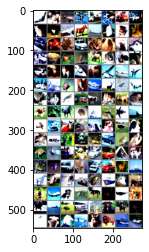

In [12]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



### Model Parameters

In [13]:
# dropout_value = 0.1

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# netobj = Net(dropout_value=0.1)
netobj = ResNet18()
model = netobj.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
        BasicBlock-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
          Dropout-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
       BasicBlock-14           [-1

### Training and Testing Loss

In [0]:
from training import train_losses, test_losses, train_acc, test_acc

In [15]:
from torch.optim.lr_scheduler import StepLR


model =  netobj.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)


EPOCHS = 50
for epoch in range(EPOCHS):
    if epoch > 6:
      scheduler.step()
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer,  epoch)
    test(model, device, test_loader)
print('Finished Training')

  0%|          | 0/391 [00:00<?, ?it/s]

lr=  0.1
EPOCH: 0


Loss=1.6430639028549194 Batch_id=390 Accuracy=33.23: 100%|██████████| 391/391 [00:29<00:00, 14.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 4634/10000 (46.34%)

lr=  0.1
EPOCH: 1


Loss=1.3828554153442383 Batch_id=390 Accuracy=52.31: 100%|██████████| 391/391 [00:29<00:00, 14.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 5670/10000 (56.70%)

lr=  0.1
EPOCH: 2


Loss=1.0037267208099365 Batch_id=390 Accuracy=62.16: 100%|██████████| 391/391 [00:29<00:00, 14.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 6574/10000 (65.74%)

lr=  0.1
EPOCH: 3


Loss=0.8625386357307434 Batch_id=390 Accuracy=69.33: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7144/10000 (71.44%)

lr=  0.1
EPOCH: 4


Loss=0.5775644779205322 Batch_id=390 Accuracy=73.86: 100%|██████████| 391/391 [00:29<00:00, 14.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7463/10000 (74.63%)

lr=  0.1
EPOCH: 5


Loss=0.5710172057151794 Batch_id=390 Accuracy=77.35: 100%|██████████| 391/391 [00:29<00:00, 14.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7703/10000 (77.03%)

lr=  0.1
EPOCH: 6


Loss=0.6360445022583008 Batch_id=390 Accuracy=80.46: 100%|██████████| 391/391 [00:29<00:00, 14.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7820/10000 (78.20%)

lr=  0.1
EPOCH: 7


Loss=0.6597480773925781 Batch_id=390 Accuracy=82.66: 100%|██████████| 391/391 [00:29<00:00, 14.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7935/10000 (79.35%)

lr=  0.1
EPOCH: 8


Loss=0.42530569434165955 Batch_id=390 Accuracy=84.99: 100%|██████████| 391/391 [00:29<00:00, 14.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7999/10000 (79.99%)

lr=  0.05
EPOCH: 9


Loss=0.3369535803794861 Batch_id=390 Accuracy=89.43: 100%|██████████| 391/391 [00:29<00:00, 14.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8346/10000 (83.46%)

lr=  0.05
EPOCH: 10


Loss=0.26531553268432617 Batch_id=390 Accuracy=91.14: 100%|██████████| 391/391 [00:29<00:00, 14.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8398/10000 (83.98%)

lr=  0.05
EPOCH: 11


Loss=0.22441796958446503 Batch_id=390 Accuracy=92.02: 100%|██████████| 391/391 [00:29<00:00, 14.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8454/10000 (84.54%)

lr=  0.025
EPOCH: 12


Loss=0.20265106856822968 Batch_id=390 Accuracy=94.94: 100%|██████████| 391/391 [00:29<00:00, 14.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8568/10000 (85.68%)

lr=  0.025
EPOCH: 13


Loss=0.09339599311351776 Batch_id=390 Accuracy=96.09: 100%|██████████| 391/391 [00:29<00:00, 14.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8603/10000 (86.03%)

lr=  0.025
EPOCH: 14


Loss=0.031268227845430374 Batch_id=390 Accuracy=96.67: 100%|██████████| 391/391 [00:29<00:00, 14.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8624/10000 (86.24%)

lr=  0.0125
EPOCH: 15


Loss=0.055561721324920654 Batch_id=390 Accuracy=98.06: 100%|██████████| 391/391 [00:29<00:00, 14.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8687/10000 (86.87%)

lr=  0.0125
EPOCH: 16


Loss=0.054308224469423294 Batch_id=390 Accuracy=98.47: 100%|██████████| 391/391 [00:29<00:00, 14.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8684/10000 (86.84%)

lr=  0.0125
EPOCH: 17


Loss=0.016021311283111572 Batch_id=390 Accuracy=98.72: 100%|██████████| 391/391 [00:29<00:00, 14.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8698/10000 (86.98%)

lr=  0.00625
EPOCH: 18


Loss=0.01639035902917385 Batch_id=390 Accuracy=99.09: 100%|██████████| 391/391 [00:29<00:00, 14.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8712/10000 (87.12%)

lr=  0.00625
EPOCH: 19


Loss=0.026309490203857422 Batch_id=390 Accuracy=99.35: 100%|██████████| 391/391 [00:29<00:00, 14.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8710/10000 (87.10%)

lr=  0.00625
EPOCH: 20


Loss=0.017419733107089996 Batch_id=365 Accuracy=99.38:  93%|█████████▎| 365/391 [00:27<00:01, 13.60it/s]

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
axs[0].plot(train_acc)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Accuracy")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("Accuracy")

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [0]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = model(images.cuda())

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [0]:
# get the image from the dataloader
# testloader2 = transforme.testloader2
it = iter(test_grad_loader)

In [0]:
import gradcam
img,_ = next(it)
gradcam.gradcamof(model, img, classes)

In [0]:
img,_ = next(it)
gradcam.gradcamof(model, img, classes)

In [0]:
img,_ = next(it)
gradcam.gradcamof(model, img, classes)

In [0]:
img,_ = next(it)
gradcam.gradcamof(model, img, classes)

In [0]:
img,_ = next(it)
gradcam.gradcamof(model, img, classes)

In [0]:
img,_ = next(it)
gradcam.gradcamof(model, img, classes)